Latent Dirichlet Allocation (LDA) adalah sebuah metode untuk mendeteksi topik-topik yang ada pada koleksi dokumen beserta proporsi kemunculan topik tersebut, baik di koleksi maupun di dokumen tertentu. LDA juga mampu mengasosiasikan kata-kata yang ada pada dokumen dan koleksi ke topik tertentu. Kasus disini menggunakan LDA untuk mendeteksi topik-topik yang ada pada kumpulan tweet

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import gensim
import nltk

from nltk.stem.snowball import SnowballStemmer

from gensim.corpora import Dictionary, MmCorpus
from gensim.models import ldamodel

from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

In [2]:
def load_dataset(filename):
    # Membuka file dengan nama yang diberikan sebagai input
    file = open(filename, 'r')  # Membuka file dalam mode baca

    # Membuat dua list kosong untuk menyimpan nama akun dan tweet
    acc_names = []  # List untuk menyimpan nama akun
    tweets = []     # List untuk menyimpan tweet

    # Membaca file baris per baris
    for line in file:
        line = line.strip()  # Menghapus spasi atau karakter kosong di awal/akhir baris
        parts = line.split('###')  # Memisahkan baris menjadi dua bagian berdasarkan pemisah '###'
        acc_names.append(parts[0])  # Menambahkan bagian pertama (nama akun) ke `acc_names`
        tweets.append(parts[1])     # Menambahkan bagian kedua (isi tweet) ke `tweets`

    # Mengembalikan kedua list: nama akun dan tweet
    return acc_names, tweets

Hyper-parameter yang perlu ditentukan pertama kali adalah "banyaknya topik" yang akan ditemukan oleh LDA. Di satu sisi, ini sepertinya adalah kelemahan vanilla LDA karena tidak bisa menentukan banyaknya topik secara otomatis. Namun, saat ini, sudah ada banyak varian dari LDA yang mampu menentukan topik secara otomatis, termasuk salah satunya adalah Hierachical Dirichlet Process (HDP)

In [3]:
# config variables
num_topics=4

In [4]:
# Import library SnowballStemmer untuk stemming
stemmer = SnowballStemmer("english")
# Mendefinisikan daftar stopwords dalam bahasa Inggris
stopwords = nltk.corpus.stopwords.words('english')

# Fungsi untuk melakukan pre-processing pada teks
def preprocess(text):

    # 1. Tokenizing dan mengubah semua kata menjadi huruf kecil
    tokens = [word.lower() for word in text.split()]
    filtered_tokens = []

    # 2. Menyaring token: hanya mengambil kata yang alfabet dan bukan stopword
    for token in tokens:
        if re.search('[a-zA-Z]', token) and (token not in stopwords):
            filtered_tokens.append(token)

    # 3. Melakukan stemming pada token yang telah disaring menggunakan Snowball Stemmer
    stems = [stemmer.stem(t) for t in filtered_tokens]

    # Mengembalikan daftar kata setelah pre-processing
    return stems

In [5]:
# Membaca dataset dari file "twitter.txt"
acc_names, tweets = load_dataset("twitter.txt")

# Melakukan pre-processing pada setiap tweet menggunakan list comprehension
tweets = [preprocess(tweet) for tweet in tweets]

# Menampilkan tweet ke-50 setelah proses pre-processing
print(tweets[49])

['this', 'manipul', 'spanish', 'knew', 'problem', 'catalunya', 'pp', 'el', 'care', 'referendum', 'valid', 'let', 'vote.ignor', 'el', 'pai']


In [6]:
# Membuat dictionary dari korpus tweets
dictionary = Dictionary(tweets)

# Memfilter kata-kata yang terlalu sering atau terlalu jarang
dictionary.filter_extremes(no_below=2, no_above=0.9)

# Mengubah tweets menjadi representasi bag-of-words
corpus = [dictionary.doc2bow(tweet) for tweet in tweets]

In [7]:
corpus

[[(0, 2), (1, 1)],
 [(0, 1), (2, 1), (3, 2)],
 [(4, 1)],
 [(0, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(5, 1), (6, 1), (7, 1)],
 [(0, 1), (9, 1), (10, 1)],
 [(0, 1), (7, 1), (11, 1), (12, 1)],
 [(0, 1), (5, 1), (7, 1), (8, 1), (13, 1), (14, 1)],
 [(5, 1), (7, 1), (10, 1), (14, 1), (15, 1), (16, 1)],
 [(5, 1), (7, 1), (9, 1)],
 [(0, 1)],
 [(0, 1)],
 [(5, 1), (7, 1), (11, 1), (12, 1), (14, 1), (17, 1), (18, 1)],
 [(1, 1), (3, 1), (5, 1), (7, 1), (14, 1)],
 [(0, 1)],
 [(5, 1), (7, 2), (14, 2)],
 [(0, 1), (5, 1), (7, 1), (19, 1)],
 [(0, 1), (4, 1)],
 [(20, 1), (21, 1)],
 [(20, 1), (21, 1), (22, 1), (23, 1)],
 [(13, 1), (20, 1), (24, 1)],
 [(25, 1), (26, 1), (27, 1)],
 [(20, 1), (21, 1), (23, 1)],
 [(20, 1), (21, 1), (26, 1)],
 [(20, 1), (28, 1)],
 [(20, 1), (21, 1), (29, 1)],
 [(20, 1), (21, 1), (30, 1), (31, 1), (32, 1), (33, 1)],
 [(20, 1), (21, 1), (30, 1), (31, 1)],
 [(3, 1), (18, 1), (20, 1), (21, 1)],
 [(19, 1), (20, 1), (21, 2), (33, 1), (34, 1)],
 [(20, 1), (21, 1), (22, 1), (29, 1)

In [8]:
# Run the LDA !
lda = ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=1, iterations=5000)

In [9]:
# Menampilkan topic matrix
topics_matrix = lda.show_topics(formatted=False)

# Iterasi setiap topik dan tampilkan kata-kata yang terkait dengan topik tersebut
for topic_no, topic_words in topics_matrix:

    print ('topic number: {}'.format(topic_no))

    # Menampilkan kata-kata dengan probabilitas tertinggi untuk setiap topik
    for word, prob in topic_words:
        print (word, prob)

topic number: 0
referendum 0.12604268
catalunya 0.09850918
iphon 0.09738426
catalan 0.07174972
spanish 0.04418777
referendum, 0.030801537
support 0.030709567
stop 0.030667704
polic 0.030652247
poll 0.030531254
topic number: 1
samsung 0.123161204
galaxi 0.07659603
note 0.07596556
iphon 0.054410517
champion 0.052634075
leagu 0.030970046
referendum 0.030142874
year 0.029580044
get 0.029486915
play 0.02942858
topic number: 2
champion 0.11865913
leagu 0.11773976
samsung 0.047095202
galaxi 0.046883218
iphon 0.033681087
catalunya 0.03317142
block 0.03251659
support 0.032458153
premier 0.03238325
lost 0.032329824
topic number: 3
full 0.073688045
champion 0.05741249
leagu 0.056969095
referendum 0.04028616
samsung 0.03970258
galaxi 0.03953577
note 0.03928005
got 0.039073676
atletico 0.038903702
chelsea 0.038887776


In [10]:
# Membentuk vektor tweet berdasarkan probabilitas terhadap topik
tweet_vectors = []
for tweet in tweets:
    probs = [prob for (_, prob) in lda.get_document_topics(dictionary.doc2bow(tweet))]
    tweet_vectors.append(probs)
tweet_vectors = np.array(tweet_vectors)

# Tentukan jumlah cluster berdasarkan jumlah topik
num_clusters = num_topics

# Terapkan algoritma K-Means untuk clustering
km = KMeans(n_clusters=num_clusters)
km.fit(tweet_vectors)

# Dapatkan indeks cluster untuk setiap tweet
clusters = km.labels_.tolist()

# Tampilkan hasil cluster
clusters

  File "C:\Users\annis\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[3,
 2,
 3,
 0,
 0,
 1,
 2,
 0,
 1,
 1,
 3,
 3,
 1,
 2,
 3,
 2,
 2,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 0,
 3]

In [11]:
# untuk setiap cluster center, kita sort argumen/index berdasarkan nilai probabilitasnya
# karena index/argumen adalah id topik.
# jadi, secara intuisi, ini adalah cara untuk mencari topik major yang dibicarakan di sebuah cluster
# nantinya, wakil kata cluster akan diambil dari 2 topik major di setiap cluster
# ::-1 artinya reverse list

# Mengurutkan indeks topik di setiap pusat cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

cluster_names = {}
for i in range(num_clusters):
    print("cluster %d words:" % i)
    
    # Ambil 2 topik utama untuk setiap cluster
    topic_words = []
    for ind in order_centroids[i, :1]:  # Ambil 1 topik utama dari setiap cluster
        topic_words += [dictionary.get(word_id) for (word_id, prob) in lda.get_topic_terms(ind, topn=2)]
    
    cluster_names[i] = ','.join(topic_words)  # Gabungkan kata-kata topik untuk nama cluster

    print(cluster_names[i])

cluster 0 words:
champion,leagu
cluster 1 words:
full,champion
cluster 2 words:
samsung,galaxi
cluster 3 words:
referendum,catalunya


In [12]:
# Reduksi dimensi dengan MDS (Multidimensional Scaling)
mds = MDS(n_components=2)
pos = mds.fit_transform(tweet_vectors)  # Reduksi dimensi ke 2D

# Ambil hasil reduksi ke 2D untuk posisi x dan y agar bisa di-plot di bidang kartesius
xs, ys = pos[:, 0], pos[:, 1]

In [13]:
# fungsi yang digunakan untuk plot cluster dokumen berdsarkan distribusi topik yang dimilikinya
# xs adalah posisi axis dari semua dokumen (numpy list of real number)
# ys adalah posisi ordinat dari semua dokumen (numpy list of real number)
# clusters adalah list dari cluster index untuk masing-masing dokumen
# acc_names adalah list dari nama-nama dokumen (dalam hal ini, nama-nama akun tweet)
# Fungsi untuk plot cluster dokumen
def plot_doc_cluster(xs, ys, clusters, acc_names):
    # Warna cluster
    cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

    # Gunakan Pandas untuk grouping data berdasarkan cluster
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, acc_names=acc_names))
    groups = df.groupby('label')  # Group berdasarkan cluster

    # Plot
    fig, ax = plt.subplots(figsize=(17, 9))
    ax.margins(0.05)

    # Plot setiap kelompok cluster
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)  # Menampilkan legenda dengan 1 titik
    print(df)
    # Menampilkan nama akun tweet di setiap titik
    for i in range(len(df)):
        ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['acc_names'], size=8)

    plt.show()

# Fungsi untuk plot distribusi kata per-topik
def plot_word_dist_per_topic(topic_no, topics_matrix, width=0.5):
    _, topic_words = topics_matrix[topic_no]

    # Ambil top-10 kata dengan probabilitas tertinggi
    words = []
    probs = []
    for word, prob in topic_words:
        words.append(word)
        probs.append(prob)

    ind = np.arange(len(words))

    # Bar chart
    plt.bar(ind, probs, width=width)
    plt.xticks(ind + width/2, words, rotation='vertical')
    plt.title('Word Distribution of Topic {}'.format(topic_no))
    plt.show()

           x         y  label         acc_names
0  -0.307819  0.421929      3   @carissalanders
1   0.726144  0.220156      2       @neilcybart
2  -0.175552  0.258275      3         @OmarSnsd
3   0.266312 -0.657775      0          @lisagae
4   0.316595 -0.296491      0       @MilkyBillz
5  -0.504991 -0.351274      1          @namivil
6   0.729867  0.223537      2    @Cortney_Annie
7   0.406521 -0.239183      0         @beebomco
8   0.397429  0.567505      1      @geekyranjit
9   0.313426  0.050095      1          @Precy_Q
10 -0.167329  0.250697      3    @xenia_is_mine
11 -0.167341  0.250678      3        @Drew_1981
12 -0.236010 -0.309161      1     @AnimenzzzThe
13  0.759992  0.233398      2        @EliMagers
14 -0.167414  0.250715      3   @DMMachineBroke
15  0.760581  0.234652      2      @brianhurley
16  0.729555  0.222639      2    @precious23445
17 -0.264903  0.368303      3   @AJ170_iOS_King
18  0.226672 -0.525809      0            @fcbgm
19  0.260456 -0.639322      0    @ManLik

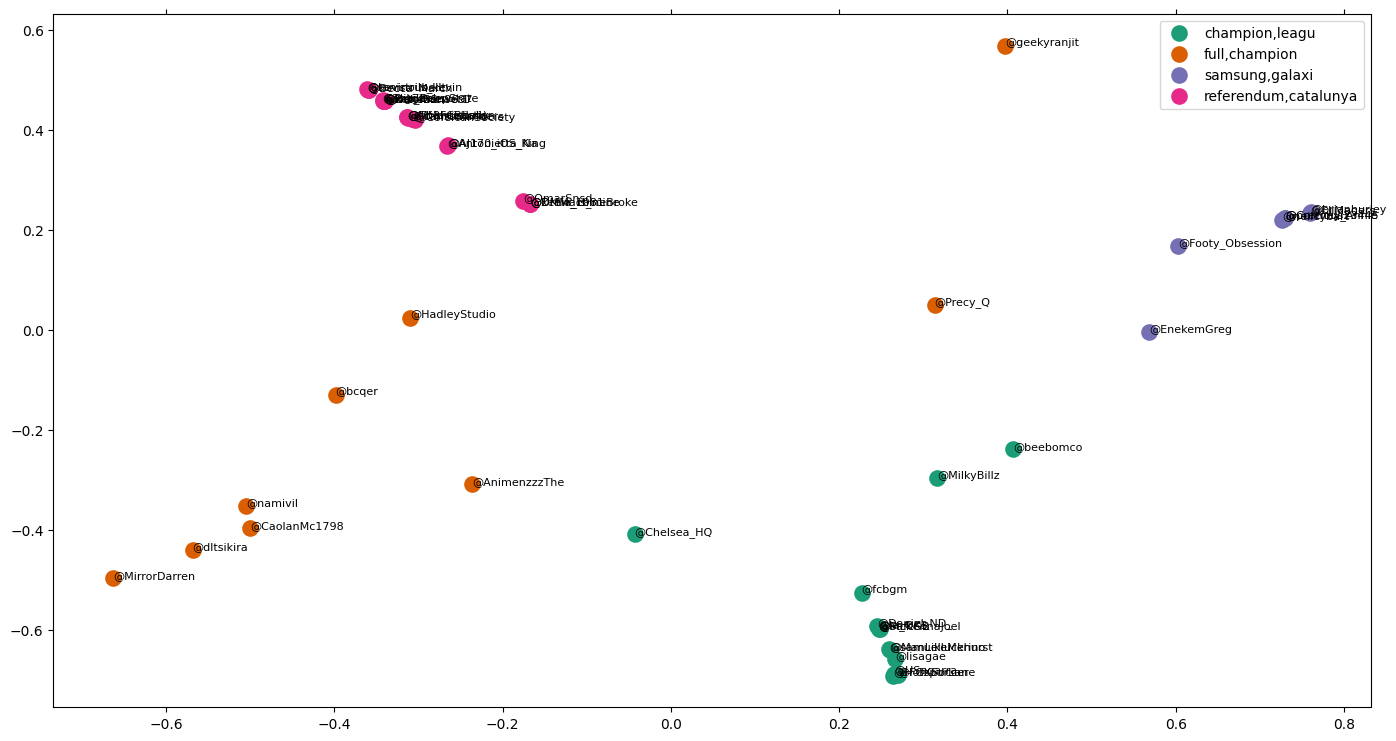

In [14]:
# Memanggil fungsi plot_doc_cluster
plot_doc_cluster(xs, ys, clusters, acc_names)

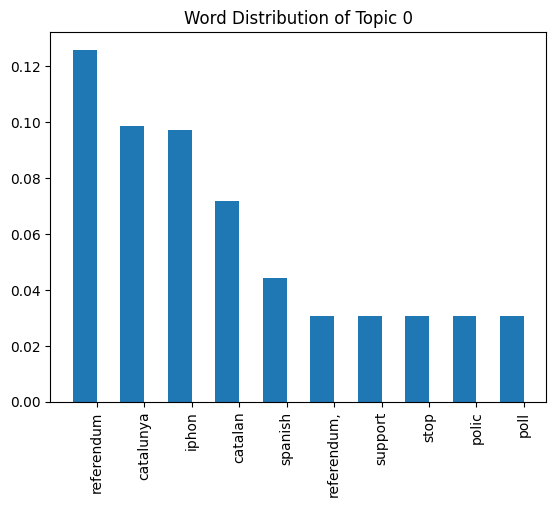

In [15]:
# plot word distribution untuk topic 0
plot_word_dist_per_topic(0, topics_matrix)

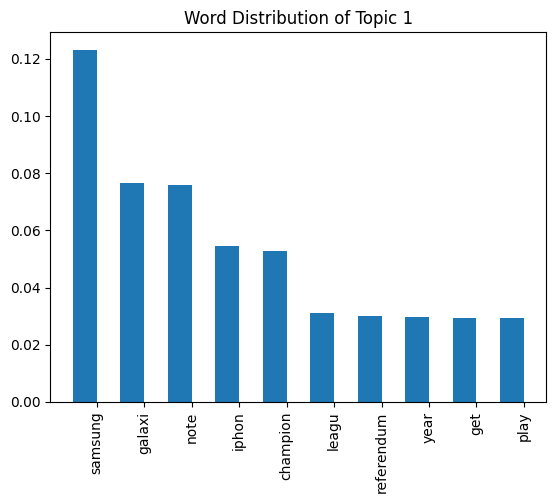

In [16]:
# plot word distribution untuk topic 1
plot_word_dist_per_topic(1, topics_matrix)

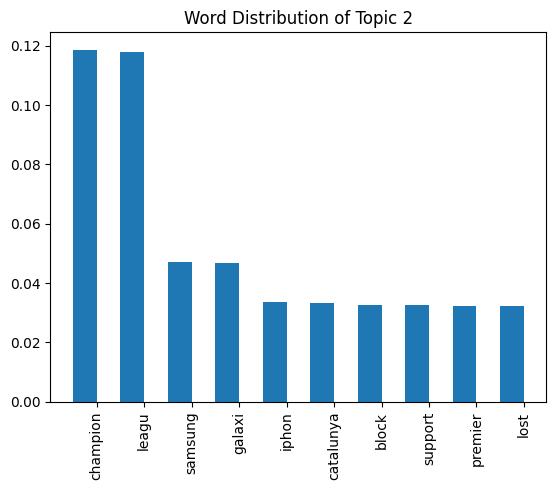

In [17]:
# plot word distribution untuk topic 2
plot_word_dist_per_topic(2, topics_matrix)

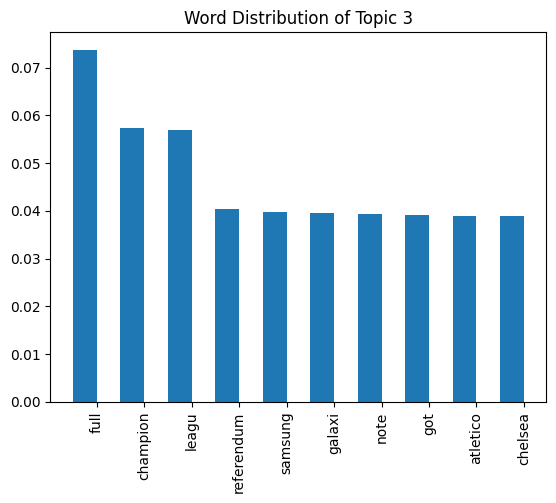

In [18]:
# plot word distribution untuk topic 3
plot_word_dist_per_topic(3, topics_matrix)